In [4]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size when solving the eigenvector problem, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors finded should be flipped in terms of their sign to obtain always the same result.
* Data should be centered inside the method (so the data has zero mean, but the std remains the same), being careful to also center the new data points.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

## Explicación teórica del algoritmo 

Dado un conjunto de $n$ datos de dimensión $d$, expresado matricialmente como $X \in \R^{n \times d}$ se pretende reducir su dimensionalidad  a $p < d$  resultando $\hat X \in \R^{n \times p}$ con la restricción de maximizar la varianza de los datos resultantes. 

- Para ello se realizará una transformación  $\phi$ de los datos. 
- Para después realizar una proyección de los datos $V \phi(X)$.
Supondremos que $\bar{\phi(X)} = 0$

Con una notación de vector por filas, la varianza de los dados vendrá dada por 
$$S = \frac{1}{N} \phi(x_i) \phi(x_i)^T.$$


Podemos expresar el problema como uno de optimización: 
donde $u$ será el vector a proyectar,imponemos  que sea de norma 1 para evitar. 
(Para una dimensión)
$$\max_{u} Var(u X) + \lambda (1 - u u^T)$$
$$
\max_{u} \frac{1}{N} u  + \lambda (1 - u u^T)
$$

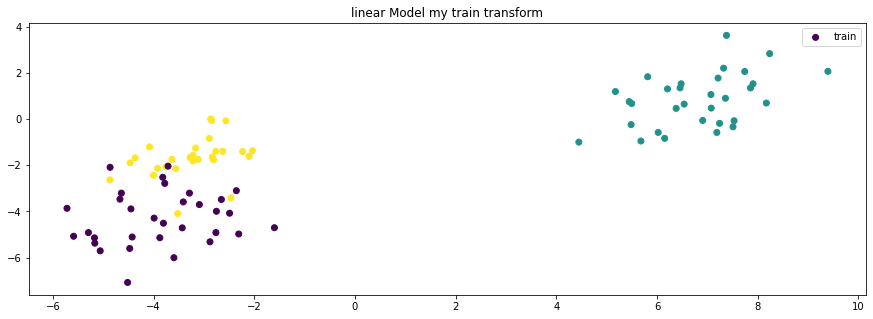

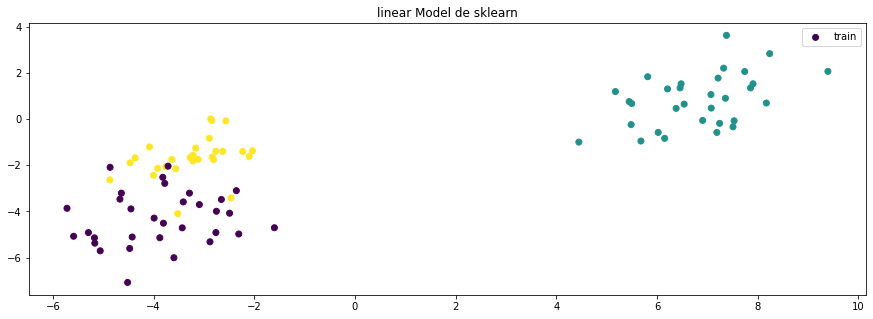

In [95]:
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.preprocessing import KernelCenterer, StandardScaler
from scipy.sparse.linalg import eigs

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel, gamma=None):
        '''
        Configuración de los valores iniciales para el método de reducción de dimensionalidad Kernel PCA
        Parámetros: 
        - `n_component`: número de componentes. 
        - `kernel`: string o function, si es un string debe de ser `linear` o `rbf`
        - `gamma : float `: Hiperparámetro del método de Kernel PCA 
        '''
        # Assignment of the hyper-parameters (complete).
        
        self.n_components = n_components # Dimensión a reducir 
        self.kernel = kernel

        # Comprobaciones del gamma 
        if gamma != None and not (isinstance(gamma, float) or isinstance(gamma, int)) :
            raise AttributeError(f'Not valid gamma type, should be an integer or float but {type(gamma)} found')
        if (isinstance(gamma, float) or isinstance(gamma, int)) and gamma < 0: 
            raise AttributeError(f'Not valid gamma value, should be positive but {gamma} found')
        
        # Asignamos una función adicional
        if self.kernel == 'rbf':
            self.kernel_function= lambda X, Y : rbf_kernel(X, Y, gamma)
        elif self.kernel == 'linear':
            self.kernel_function = lambda X, Y: linear_kernel(X, Y)
        elif callable(kernel): # Permitimos que además se le pueda añadir una función adicional
            self.kernel_function = kernel
        else:
            raise AttributeError(f'Not valid kernel type: {self.kernel}')

        # Scaler
        self.scaler = StandardScaler(with_std = False) # No queremos que nos modifique la varianza de los datos (pero sí la media)

    def fit(self, X):
        # Computation of the projection direction (complete).
        # ...
        #self.scaler.fit(X) # Trasladamos los datos para que tenga media 0
        #self.X_centered = self.scaler.transform(X)
        #X = self.X_centered
        self.X_fit = X
        # Sacamos el kernel
        K = np.array(self.kernel_function(X, X))
        
        self.transformer = KernelCenterer().fit(K)
        self.centered_kernel_matrix= self.transformer.transform(K)
        
        
        valores_propios , vectores_propios = eigs(self.centered_kernel_matrix, self.n_components)
        self.vectores_propios = vectores_propios.real.T

        vectores_propios = list(map(self._flip, self.vectores_propios))
        
        valor_vector = list(zip(valores_propios.real, self.vectores_propios))
        self.valores_propios = valores_propios.real

        # ordenamos en orden de vector propio
        valor_vector.sort(key = lambda k: k[0], reverse = True) 
       
        
        # Escalar la a  y orientar 
        self.a_escalada = list( map( lambda k: k[1]/ np.sqrt(k[0]), valor_vector) )
        
        # Guardamos los valores
        self.L = list( map( lambda k: np.sqrt(k[0]), valor_vector) )
        
        return self

    def transform(self, X):
        # Computation of the projected components (complete).
        # TODO comprobar el funcionamiento de la matriz de kernel centrada
        
        kernel_matrix = self.kernel_function(X, self.X_fit) # Kernel sin centrar
        kernel_matrix = self.transformer.transform(kernel_matrix) # central kernel
        return self.a_escalada @ kernel_matrix

    def fit_transform(self, X ):
        # Computation of the projected components over X just after training with it (complete).
        # Este sería la buena, pa no tener que almacenarla

        return None


    def _flip(self, v):
        '''Nos quedamos con el vector positivo'''
        if v[0] > 0:
            return v *-1
        return v
    

# --- Borrar --- Prueba el rbf
def muestraSimple(Xx,Xy, Y, title):
    plt.scatter(Xx, Xy,c=Y, label='train')
    plt.title(title)
    plt.legend()
    plt.show()
    
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_blobs

#kernel = 'rbf'
kernel = 'linear'
n_components=1

X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

# Model definition
model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = KernelPCA(kernel=kernel, n_components=n_components)

# Training of the models 
model_my.fit(X_train)
model_sk.fit(X_train)
muestraSimple(model_my.transform(X_train), X_train[:,1],y_train,f'{kernel} Model my train transform')
muestraSimple(model_sk.transform(X_train), X_train[:,1],y_train,f'{kernel} Model de sklearn')
        

       

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

(90, 2)


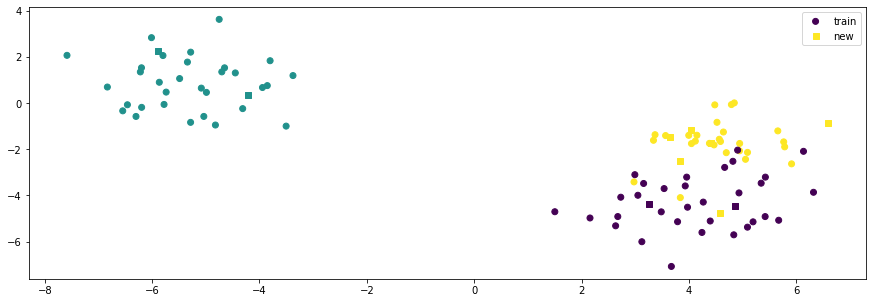

In [42]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]
print(X_train.shape)
# Borrar
#X_train = np.array([[1 ,-1], [0,1], [2,0]])
#y_train = np.array([1,-1,1])

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

def muestraSimple(Xx,Xy, Y, title):
    plt.scatter(Xx, Xy,c=Y, label='train')
    plt.title(title)
    plt.legend()
    plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

## Explicación 

### Apartado 2: Comparative of the eigenvectors 

#### Obtención vector propio para PCA 

De acorde a la documentación oficial de sklearn para PCA [ver](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) consultada por última vez el 22 de noviembre del 2022. 
El atributo `components_` devuelve: 
```
components_ndarray of shape (n_components, n_features)
Principal axes in feature space, representing the directions of maximum variance in the data. Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors. The components are sorted by explained_variance_.
```

Es decir PCA calcula $ X = U D_X V^T$ y devuelve el vector propio $v_1$ asociado al mayor valor propio. Esto tiene la ventaja de que permite decir la dirección en que la varianza es máxima. 

En nuestro caso,calculamos la matriz de covarianza $\Sigma$
$\Sigma =  U D_\Sigma V^T$. 

Como resultado de esto se verá que difieren en tamaño, que es lo que procedemos a mostrar en el código de ejemplo. 


### Apartado 3: Comparación de las proyecciones  

La comparación se hará de manera visual

In [7]:
from sklearn.decomposition import PCA



kernel = 'linear'
n_components=1

model_my = KPCA(n_components=n_components, kernel='linear')
model_sk = PCA(n_components=n_components)

# Apartado 1: Training of the model
model_my.fit(X_train)
model_sk.fit(X_train)

# Apartado 2: Comparative of the eigenvectors.
# ...
print('Sklearn tamaño de los componentes',model_sk.components_.shape)
print('Nuestra implementación, tamaño vector ',model_my.a_escalada[0].shape)


# Comparative of the projections 


Sklearn tamaño de los componentes (1, 2)
Nuestra implementación, tamaño vector  (90,)


In [8]:
model_my.fit_transform(X_train)

array([[ 0.07580306-0.05527369j,  0.1304898 -0.01561715j,
        -0.37993094-0.01061177j,  0.14067667+0.01862233j,
         0.12006893-0.0234122j , -0.3769921 -0.00117571j,
         0.16881301-0.02481745j, -0.01136015-0.05963114j,
         0.23298152+0.04981344j,  0.06886911-0.04809049j,
        -0.27137604+0.04124072j,  0.17598039+0.01651396j,
        -0.38964377+0.03663375j,  0.18231546-0.04519872j,
        -0.23264195+0.03595585j, -0.19507238+0.08123614j,
         0.12090639-0.06179546j,  0.07092293-0.0243618j ,
         0.1883981 +0.01581325j, -0.18412571+0.04961938j,
         0.09543811-0.02755284j,  0.21438421+0.02689686j,
         0.15073262+0.01877897j, -0.26118559+0.00548131j,
        -0.32393459+0.01321985j, -0.321069  +0.02119946j,
        -0.24563176+0.03568073j,  0.00732074-0.06422333j,
        -0.29015945+0.04480687j,  0.01895388-0.05596452j,
         0.20171185-0.01441457j,  0.14289091-0.05393349j,
         0.01843415-0.07580631j,  0.2720343 +0.03261455j,
         0.212

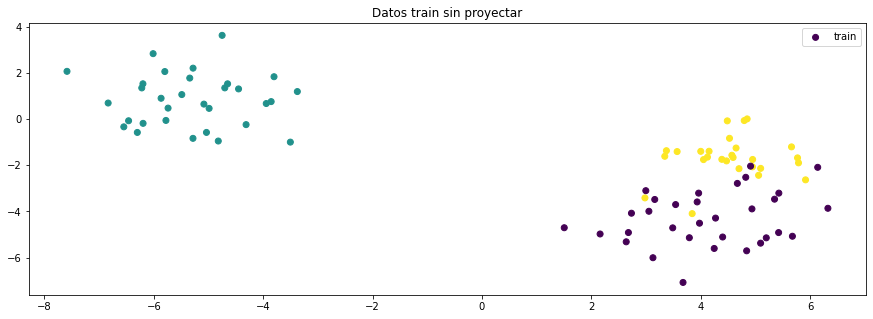

/Users/blancacanocamarero/miniforge3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


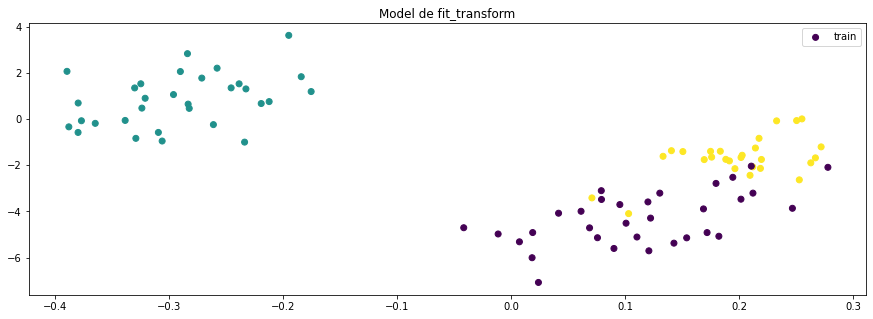

/Users/blancacanocamarero/miniforge3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


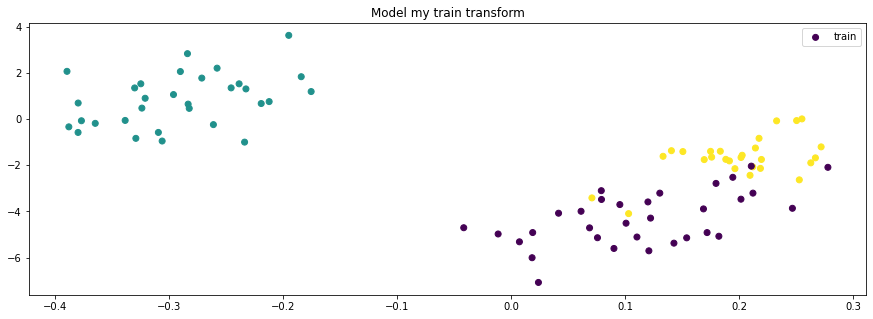

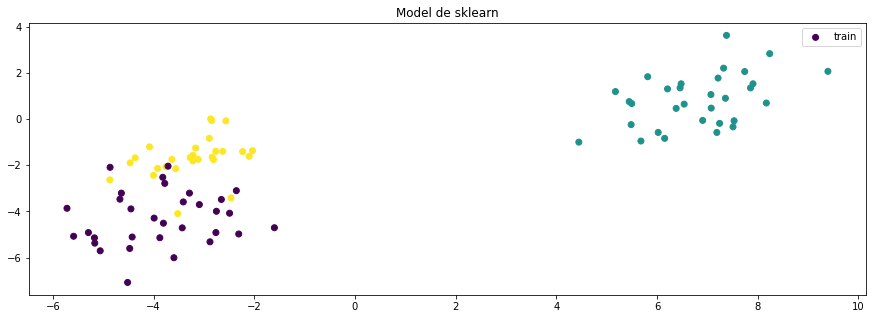

ValueError: Kernel matrix must be a square matrix. Input is a 90x10 matrix.

In [9]:
muestraSimple(X_train[:,0], X_train[:,1], y_train, 'Datos train sin proyectar')
muestraSimple(model_my.fit_transform(X_train), X_train[:,1],y_train,'Model de fit_transform')
for X_train,y_train in [(X_train,y_train), (X_new, y_new)]:
    muestraSimple(model_my.transform(X_train), X_train[:,1],y_train,'Model my train transform')
    muestraSimple(model_sk.transform(X_train), X_train[:,1],y_train,'Model de sklearn')


<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [ ]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition 
model_my = KPCA(n_components=n_components, kernel='rbf')
model_sk = KernelPCA(kernel=kernel, n_components=n_components)

# Training of the models 
model_my.fit(X_train)
model_sk.fit(X_train)

# Comparative of the eigenvectors (complete).

print('Sklearn tamaño de los componentes',model_sk.eigenvectors_.shape)
print('Nuestra implementación, tamaño vector ',model_my.a_escalada[0].shape)
print('Sklearn tamaño de los componentes',model_sk.eigenvectors_)
print('Nuestra implementación, tamaño vector ',model_my.a_escalada[0])
# Comparative of the projections (complete).
muestraSimple(X_train[:,0], X_train[:,1], y_train, 'Datos train sin proyectar')
muestraSimple(model_my.fit_transform(X_train), X_train[:,1],y_train,'Model de fit_transform')
for X_train,y_train in [(X_train,y_train), (X_new, y_new)]:
    muestraSimple(model_my.transform(X_train), X_train[:,1],y_train,'Model my train transform')
    muestraSimple(model_sk.transform(X_train), X_train[:,1],y_train,'Model de sklearn')


## Comparing linear kernel against Gaussian kernel

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

## Primero vamos a determinar el valor del gamma utilizando una rejilla de búsqueda 

La inspección será visual. 

In [ ]:
gammas = [0.01, 0.5, 1, 2, 9,10,11,12, 20]# np.linspace(0.1,5,20)
gammas = np.linspace(9,16, 20)
for g in gammas: 
    model_rbf = KPCA(n_components=n_components, kernel='rbf', gamma= g)
    
    #model_rbf = KernelPCA(n_components=n_components, kernel='rbf', gamma= g)
    model_rbf.fit(X)
    muestraSimple(model_rbf.transform(X), X[:,1],y,f'Model de transform for gamma = {g}')

In [ ]:
gamma = 12 # Valor sacado con el de sklearn

n_components=1

model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf')

# Training of the models (complete).
# ...

# Comparative of the projections (complete).
# ...